<a href="https://colab.research.google.com/github/gtimokhina/Machine-Learning/blob/master/german_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data narative:** We have historical data on loans given out with information on whether or not the borrower defaulted (charge-off).  Can we build a model that can predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. 

**Latent valiables:** property info(if owns, most likely to repay the loan), purpose of the loan, credit_history, personal_status

**Observation from data:**
 -- Single men  with age 23 to 37 are the most popular customers.
 --Car loans and radio/television are most popular as a purpose.
 --Small loan amounts with short duration are be most likely will be repayed.

**Results:** Clustering (n = 2 clusters): I got 2 good clusters for segmentation based on duration and credit amount.
1. K-means with PCA: silhouette_score: 0.32
2. GMM with PCA: silhouette_score: 0.37
3. Linear Regression. Based on visualization we can predict duration based on credit amount.
    Since the data was skewed, I  used log transformation and got better results.
    MAE: 0.347
    MSE: 0.2109
    RMSE: 0.4592

4. Logistic Regression accuracy = 75%, log transformation
5. XGBoost accuracy=77%, feature selection
6. Random Forest accuracy = 76%, k-fold gave kind of the same result
7. KNN (n=5) accuracy = 69%, selected best n
8. Naive Bayes accuracy = 72%
9. SVM accuracy  = 70%
10. PCA, used in clustering. Received much better score



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# loading numerical dataset
df_n = pd.read_fwf('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric', delim_whitespace = True, header = None)
df_n.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,3,2,1,2,1,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,3,1,1,1,1,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,3,1,2,1,1,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,3,1,2,1,1,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,3,2,2,1,1,1,0,1,0,0,0,0,0,1,2


In [2]:
# loading regular dataset
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", delim_whitespace = True, header = None) 
columns = ['checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
'saving_account', 'present_emp_since', 'inst_rate', 'personal_status',
'other_debtors', 'residence_since', 'property', 'age', 'inst_plans',
'housing', 'num_credits', 'job', 'dependents', 'telephone', 'foreign_worker', 'status']
df.columns = columns
df.head()

,checking_account,duration,credit_history,purpose,credit_amount,saving_account,present_emp_since,inst_rate,personal_status,other_debtors,residence_since,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


**Explore and visualize Data**

In [3]:
# check our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checking_account   1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   purpose            1000 non-null   object
 4   credit_amount      1000 non-null   int64 
 5   saving_account     1000 non-null   object
 6   present_emp_since  1000 non-null   object
 7   inst_rate          1000 non-null   int64 
 8   personal_status    1000 non-null   object
 9   other_debtors      1000 non-null   object
 10  residence_since    1000 non-null   int64 
 11  property           1000 non-null   object
 12  age                1000 non-null   int64 
 13  inst_plans         1000 non-null   object
 14  housing            1000 non-null   object
 15  num_credits        1000 non-null   int64 
 16  job                1000 non-null   object
 

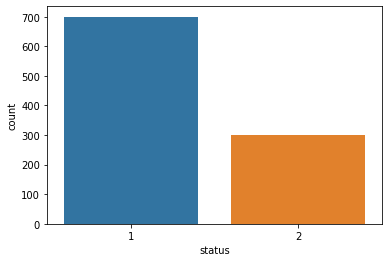

In [4]:
# lets check countplot of status, looks like we have unbalanced data
sns.countplot(x='status',data=df)

No handles with labels found to put in legend.


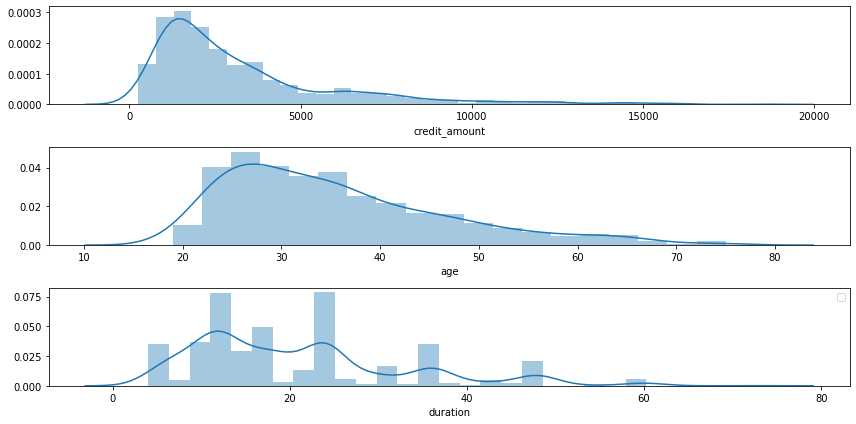

In [5]:
# let's check credit_amount,age, duration distributions 
fig, (x1, x2, x3) = plt.subplots(3,1, figsize=(12,6))
sns.distplot(df['credit_amount'],ax=x1)
sns.distplot(df['age'],ax=x2)
sns.distplot(df['duration'],ax=x3)
plt.tight_layout()
plt.legend()

No handles with labels found to put in legend.


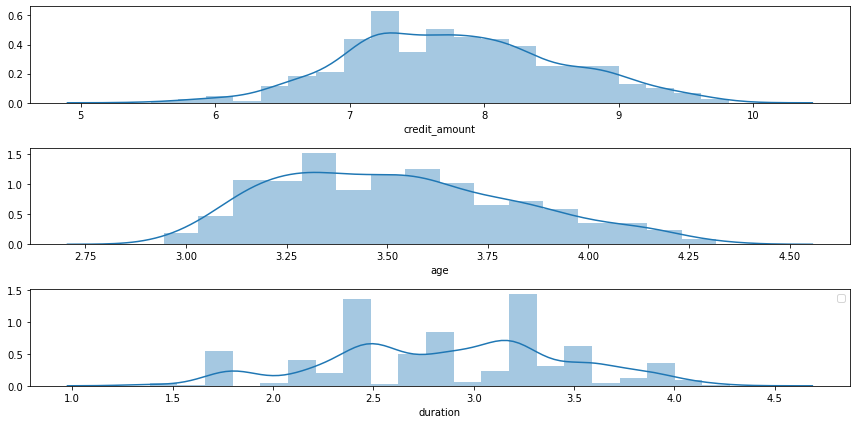

In [6]:
# data is skewed, we can try log transformation here
df_log = np.log(df[['age', 'credit_amount','duration']])
# let's check credit_amount,age, duration distributions 
fig, (x1, x2, x3) = plt.subplots(3,1, figsize=(12,6))
sns.distplot(df_log['credit_amount'],ax=x1)
sns.distplot(df_log['age'],ax=x2)
sns.distplot(df_log['duration'],ax=x3)
plt.tight_layout()
plt.legend()

# looks better

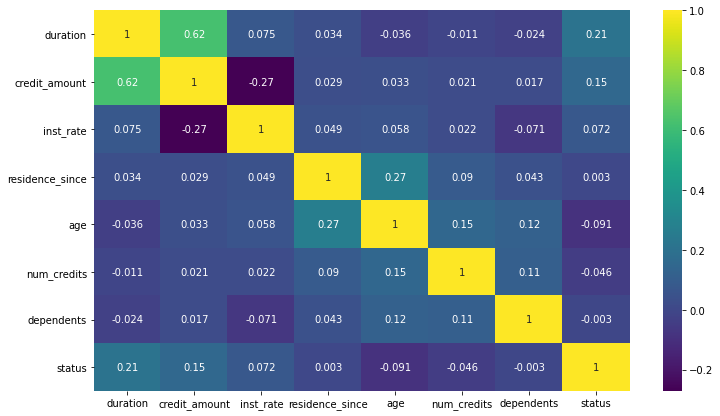

In [7]:
# check correlation. looks like credit amount and duration are correlated
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')


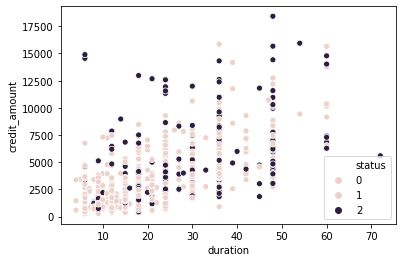

In [8]:
# the highest correlation between duration and credit_amount, explore
sns.scatterplot(x='duration',y='credit_amount',data=df, hue='status')

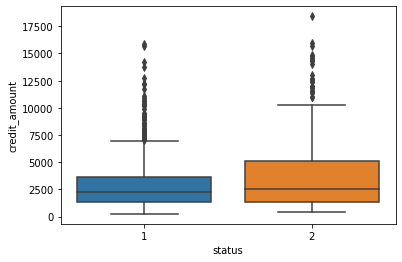

In [9]:
# check plot for credit_amount and status
sns.boxplot(x='status',y='credit_amount',data=df)

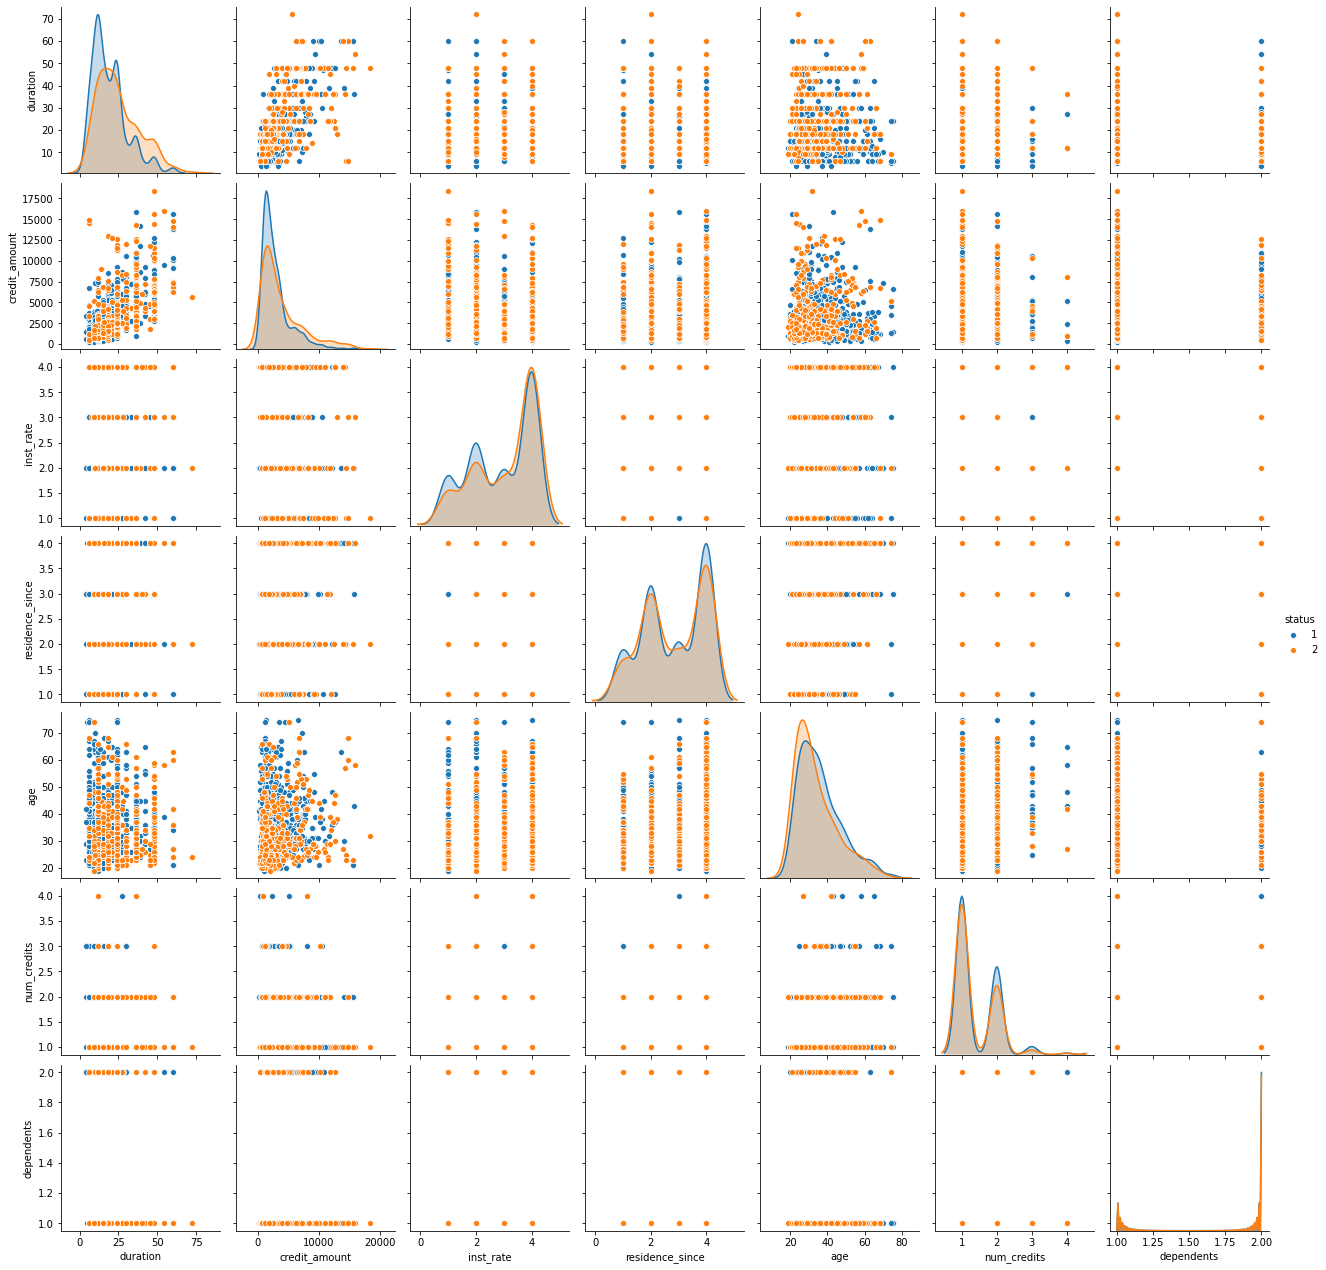

In [10]:
# pairplot
sns.pairplot(df, hue='status')


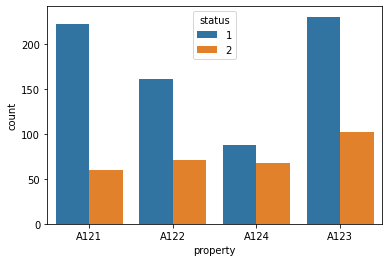

In [11]:
# check other categorial features(if property own), looks like people who own property most likely will repay the loan
sns.countplot(x='property',data=df,hue='status')

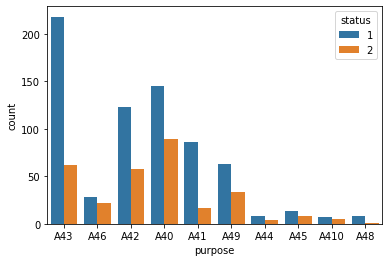

In [12]:
# check other categorial features(purpose), looks like radio/television is most popular reason for the loan
sns.countplot(x='purpose',data=df,hue='status')

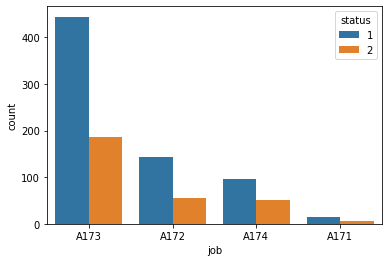

In [13]:
# looks like job status is not a good predictor, kind of the same distribution for all job statuses
sns.countplot(x='job',data=df,hue='status')

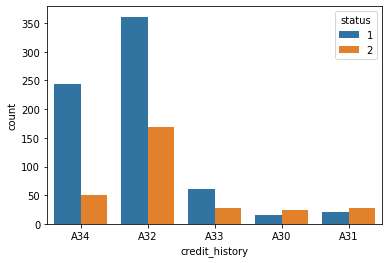

In [14]:
# showing if people have other credits(not at this bank) they mostly likely will repay the loan
sns.countplot(x='credit_history',data=df,hue='status')

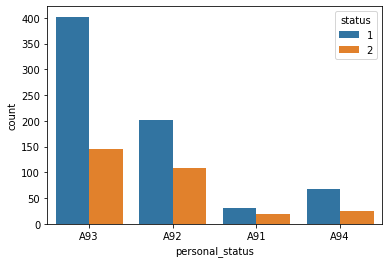

In [15]:
# most loans are taken by single males and majority will repay the loan
sns.countplot(x='personal_status',data=df,hue='status')

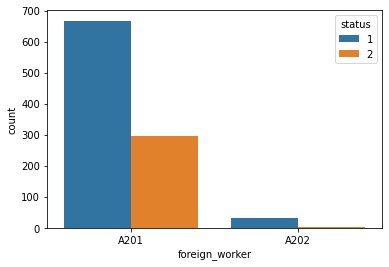

In [16]:
# majority of people who are taking loans are foreing workers
sns.countplot(x='foreign_worker',data=df,hue='status')

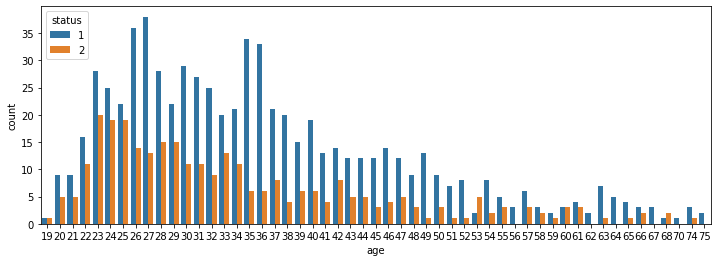

In [17]:
# majority of people who are taking loans are between age 23 and 37
plt.figure(figsize=(12,4))
sns.countplot(x='age',data=df,hue='status')

CLUSTERING

**K_means**

In [0]:
# scaling dataset
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
df_kmeans = df_log

scaler.fit(df_kmeans)
scaled_features = scaler.fit_transform(df_kmeans)

In [19]:
df_kmeans = pd.DataFrame(scaled_features)
df_kmeans.head()

,0,1,2
0,2.271006,-0.933901,-1.864869
1,-1.446152,1.163046,1.708369
2,1.226696,-0.181559,-0.673790
3,0.942455,1.525148,1.478913
4,1.488620,0.904743,0.517289


In [0]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Inertia')

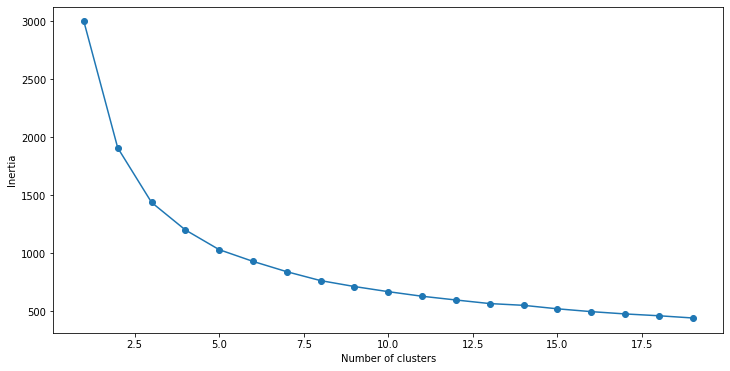

In [21]:
# check elbow method to identify number of clusters
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df_kmeans)
    SSE.append(kmeans.inertia_)

#  plot results
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [22]:
# looks like 2,3,4,5 are good numbers for clustering here
# lets check silhouette score for these numbers and select the best one
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
for cluster in range(2,6):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    y = kmeans.fit_predict(df_kmeans)
    print('silh. score for n = ' + str(cluster),silhouette_score(df_kmeans, y))

silh. score for n = 2 0.3153441336069185
silh. score for n = 3 0.3026871285047213
silh. score for n = 4 0.26711923394057535
silh. score for n = 5 0.2674532039229961


In [23]:
# try GMM
from sklearn.mixture import GaussianMixture
for cluster in range(2,6):
    gmm = GaussianMixture(n_components=cluster,covariance_type='full').fit(df_kmeans)
    y = gmm.predict(df_kmeans)
    print('gmm silh. score for n = ' + str(cluster),silhouette_score(df_kmeans, y))


gmm silh. score for n = 2 0.2919645752269785
gmm silh. score for n = 3 0.28684626456510337
gmm silh. score for n = 4 0.26072041395944084
gmm silh. score for n = 5 0.2495770045727828


In [24]:
#since we want to predict risk class and we have best silhouette_score for 2 clusters, lets try both models with 2 clusters
kmeans = KMeans(n_jobs = -1, n_clusters = 2, init='k-means++')
kmeans.fit(df_kmeans)
print(silhouette_score(df_kmeans, kmeans.labels_))


0.3153441336069185


In [25]:
# apply PCA , it is showing better silhouette_score for K-means
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_kmeans)
kmeans = KMeans(n_jobs = -1, n_clusters = 2, init='k-means++')
kmeans.fit(df_pca)
print(silhouette_score(df_pca, kmeans.labels_))

0.3646232789321084


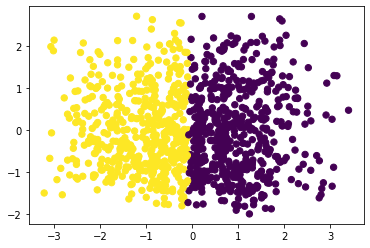

In [26]:
# visualize
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, s=40, cmap='viridis');

**GMM**

In [27]:
# using GMM for 2 clusters on PSA applied dataset
gmm = GaussianMixture(n_components=2,covariance_type='full').fit(df_pca)
gmm_labels= gmm.predict(df_pca)  

print(silhouette_score(df_pca, gmm_labels))


0.3626449115339331


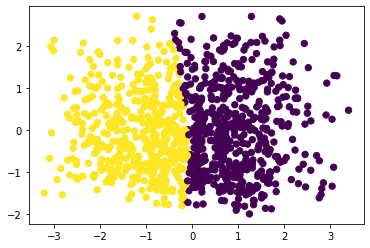

In [28]:
# visualize
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=gmm_labels, s=40, cmap='viridis')

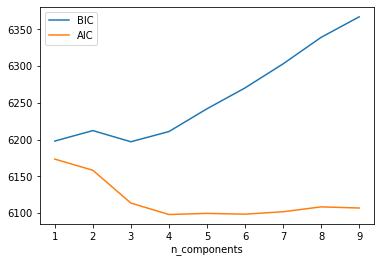

In [29]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(df_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [30]:
# check how data for each cluster for K-means
df_clustered = df.assign(cluster=kmeans.labels_)
grouped = df_clustered.groupby(['cluster']).mean().round(1)
grouped

,duration,credit_amount,inst_rate,residence_since,age,num_credits,dependents,status
cluster,,,,,,,,
0,13.0,1589.2,3.1,2.8,35.8,1.4,1.2,1.2
1,30.0,5222.2,2.9,2.9,35.3,1.4,1.1,1.4


In [31]:
# check how data for each cluster for Gmm
df_clustered = df.assign(cluster=gmm_labels)
grouped = df_clustered.groupby(['cluster']).mean().round(1)
grouped

,duration,credit_amount,inst_rate,residence_since,age,num_credits,dependents,status
cluster,,,,,,,,
0,13.3,1665.5,3.1,2.8,36.3,1.4,1.2,1.2
1,30.6,5306.7,2.8,2.9,34.5,1.4,1.2,1.4


Looks like we have good 2 clusters with diff. duration and credit amount that we can use for segmentation

**Linear Regression**

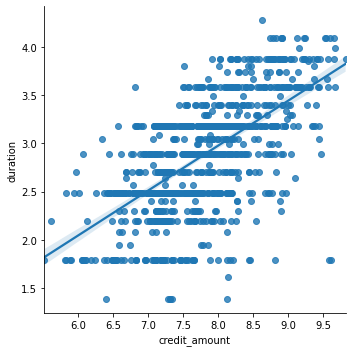

In [32]:
#Based on visualization we can predict duration based on credit amount
# since the data was scewed, I will use log trasformed data
sns.lmplot(x='credit_amount',y='duration',data=df_log)



In [0]:
from sklearn.model_selection import train_test_split
y = df_log['duration']
X = df_log.drop(['duration'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

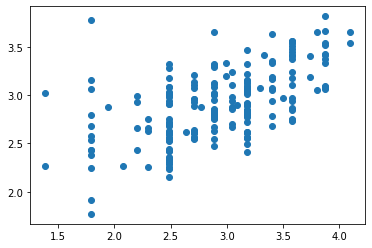

In [34]:
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
# check visually predictions vs actual values
plt.scatter(y_test,predictions)


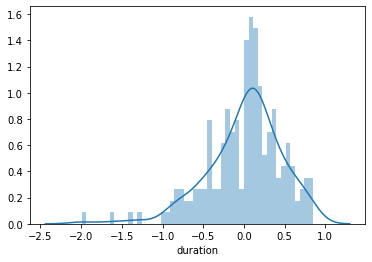

In [35]:
# histogram
sns.distplot((y_test-predictions),bins=50);

In [36]:
# check different metrics
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
from sklearn import metrics

MAE: 0.34703460544559644
MSE: 0.21093333708604323
RMSE: 0.45927479474280236


**Logistic Regression**

In [37]:
# we need to change status column to be binary 
y = df_n[24] - 1
X = df_n.drop([24], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       204
           1       0.67      0.43      0.52        96

    accuracy                           0.75       300
   macro avg       0.72      0.66      0.68       300
weighted avg       0.74      0.75      0.73       300



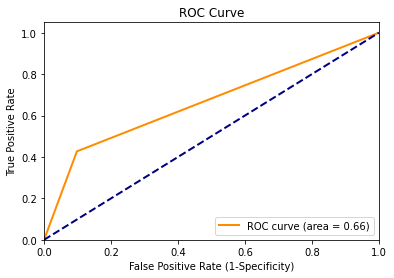

In [38]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
fpr, tpr, thresholds = metrics.roc_curve(y_test,predictions, pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show() 

**XGBoost**

In [0]:
from xgboost import XGBClassifier

In [0]:
y = df_n[24] - 1
X = df_n.drop([24], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [41]:
# fit model 
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

[0.17708094 0.04671176 0.0527551  0.0340082  0.06883388 0.0359406
 0.02625137 0.02389657 0.03861022 0.03911328 0.03290652 0.02464016
 0.02899568 0.04523575 0.00935629 0.03380649 0.03169729 0.05632414
 0.0256678  0.04881434 0.01766382 0.02950326 0.04385423 0.02833227]


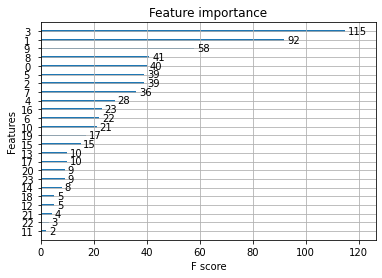

In [43]:
# feature imporatnce
print(model.feature_importances_)

# plot
from xgboost import plot_importance
plot_importance(model)
plt.show()


In [44]:
# accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.67%


In [45]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       204
           1       0.70      0.48      0.57        96

    accuracy                           0.77       300
   macro avg       0.74      0.69      0.70       300
weighted avg       0.76      0.77      0.75       300



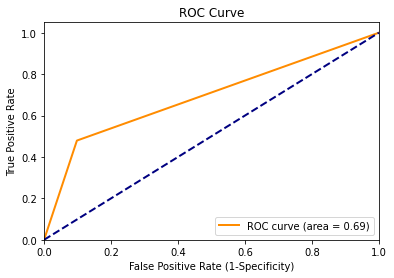

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predictions, pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show() 

Random **Forest**

In [47]:

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
y = df_n[24] - 1
X = df_n.drop([24], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       204
           1       0.73      0.34      0.47        96

    accuracy                           0.75       300
   macro avg       0.74      0.64      0.65       300
weighted avg       0.75      0.75      0.72       300

[[192  12]
 [ 63  33]]


In [48]:
# cross validation K-fold
from sklearn.model_selection import KFold
scores = [] 
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(X_train, y_train)
    scores.append(rfc.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [49]:
#Random Forest with K-folf cross validation
print(np.mean(scores))

0.757


**KNN**

In [50]:
# first scale data
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
df_feat = pd.DataFrame(scaled_features)
df_feat.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,-1.254566,-1.236478,1.344014,-0.733432,1.833169,1.338078,0.449326,1.046987,-1.293723,2.766456,0.460831,1.027079,-0.428290,1.214598,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356
1,-0.459026,2.248194,-0.503428,0.966377,-0.699707,-0.317959,-0.963650,-0.765977,-1.293723,-1.191404,0.460831,-0.704926,-0.428290,-0.823318,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356
2,1.132053,-0.738668,1.344014,-0.414718,-0.699707,0.510060,0.449326,0.140505,-1.293723,1.183312,0.460831,-0.704926,2.334869,-0.823318,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,2.0,-1.304877
3,-1.254566,1.750384,-0.503428,1.639217,-0.699707,0.510060,0.449326,1.046987,-0.341055,0.831502,0.460831,-0.704926,2.334869,-0.823318,-0.196014,-0.552705,-0.338862,-3.122929,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356
4,-1.254566,0.256953,0.420293,0.576837,-0.699707,-0.317959,0.449326,1.046987,1.564281,1.535122,0.460831,1.027079,2.334869,-0.823318,-0.196014,1.809283,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356


In [0]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.30)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

In [52]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[169  49]
 [ 46  36]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       218
           1       0.42      0.44      0.43        82

    accuracy                           0.68       300
   macro avg       0.60      0.61      0.61       300
weighted avg       0.69      0.68      0.69       300



In [0]:
# select n number
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

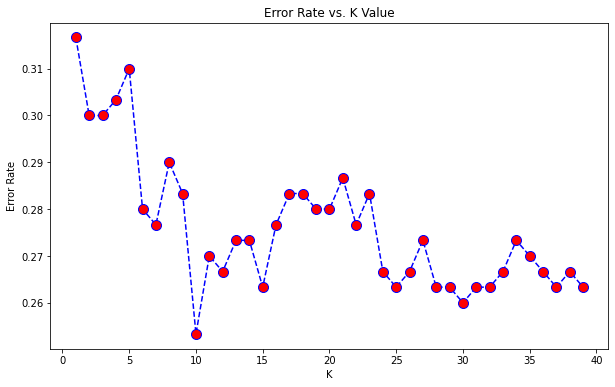

In [54]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [55]:
# retrain model with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[180  38]
 [ 55  27]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.79       218
           1       0.42      0.33      0.37        82

    accuracy                           0.69       300
   macro avg       0.59      0.58      0.58       300
weighted avg       0.67      0.69      0.68       300



with n=5 we have much better score

In [0]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
gnb = GaussianNB()
pred = gnb.fit(X_train, y_train).predict(X_test)

In [57]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       204
           1       0.55      0.66      0.60        96

    accuracy                           0.72       300
   macro avg       0.69      0.70      0.69       300
weighted avg       0.74      0.72      0.73       300



In [58]:
print(confusion_matrix(y_test,pred))

[[153  51]
 [ 33  63]]


SVM

In [59]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model = SVC()
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[203   1]
 [ 90   6]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       204
           1       0.86      0.06      0.12        96

    accuracy                           0.70       300
   macro avg       0.77      0.53      0.47       300
weighted avg       0.75      0.70      0.59       300

